## Лаба 10. Построить рекомендательную систему видеоконтента с implicit feedback

### Задача

В вашем распоряжении имеется уже предобработанный и очищенный датасет с фактами
покупок абонентами телепередач от компании E-Contenta. По доступным вам данным нужно предсказать вероятность покупки других передач этими, а, возможно, и другими абонентами.


In [1]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='--packages com.databricks:spark-csv_2.10:1.2.0 pyspark-shell'
os.environ["PYSPARK_PYTHON"]='python3'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
print(spark_home)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.4-src.zip'))
os.environ["PYSPARK_PYTHON"] = 'python3'
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

/usr/hdp/current/spark2-client
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.2.0
      /_/

Using Python version 3.4.3 (default, Nov 17 2016 01:08:31)
SparkSession available as 'spark'.


In [2]:
sc

<SparkContext master=yarn appName=pyspark-shell>

### Обработка данных на вход

Для выполнения работы вам следует взять все файлы из папки на HDFS `/labs/lab10data/`. Давайте посмотрим, что у нас есть:

```
$ hadoop fs -ls /labs/lab10data
Found 4 items
-rw-r--r--   3 hdfs hdfs   91066524 2017-05-09 13:51 /labs/lab10data/lab10_items.csv
-rw-r--r--   3 hdfs hdfs   29965581 2017-05-09 13:50 /labs/lab10data/lab10_test.csv
-rw-r--r--   3 hdfs hdfs   74949368 2017-05-09 13:50 /labs/lab10data/lab10_train.csv
-rw-r--r--   3 hdfs hdfs  871302535 2017-05-09 13:51 /labs/lab10data/lab10_views_programmes.csv
```
* В `lab10_train.csv` содержатся факты покупки (колонка `purchase`) пользователями (колонка `user_id`) телепередач (колонка `item_id`). Такой формат файла вам уже знаком.

* `lab10_items.csv` — дополнительные данные по items. В данном файле много лишней или ненужной информации, так что задача её фильтрации и отбора ложится на вас. Поля в файле, на которых хотелось бы остановиться:
  * `item_id` — primary key. Соответствует `item_id` в предыдущем файле.
  * `content_type` — тип телепередачи (`1` — платная, `0` — бесплатная). Вас интересуют платные передачи.
  * `title` — название передачи, текстовое поле.
  * `year` — год выпуска передачи, число.
  * `genres` — поле с жанрами передачи, разделёнными через запятую.
  
* `lab10_test.csv` — тестовый датасет без указанного целевого признака `purchase`, который вам и предстоит предсказать.

* Дополнительный файл `lab10_views_programmes.csv` по просмотрам передач с полями:
  * `ts_start` — время начала просмотра
  * `ts_end` — время окончания просмотра
  * `item_type`— тип просматриваемого контента:
    * `live` — просмотр "вживую", в момент показа контента в эфире
    * `pvr` — просмотр в записи, после показа контента в эфире

### Загружаем и обрабатываем данные
#### Факты покупки телепередач

In [3]:
dfs_train = spark.read.load(
    '/labs/lab10data/lab10_train.csv',
    format = "com.databricks.spark.csv",
    header = True
)

In [4]:
dfs_train.count()

5032624

In [5]:
dfs_train.show(2)

+-------+-------+--------+
|user_id|item_id|purchase|
+-------+-------+--------+
|   1654|  74107|       0|
|   1654|  89249|       0|
+-------+-------+--------+
only showing top 2 rows



Все поля имеют строковый тип, поэтому конвертируем в числовой

In [6]:
dfs_train_1 = dfs_train.select(
    dfs_train.user_id.cast('integer'),
    dfs_train.item_id.cast('integer'),
    dfs_train.purchase.cast('integer')
)

Число фактов покупки

In [7]:
dfs_train_1.filter(dfs_train_1.purchase==1).count()

10904

#### Описание телепередач

In [8]:
sc.textFile('/labs/lab10data/lab10_items.csv').take(2)

['item_id\tchannel_id\tdatetime_availability_start\tdatetime_availability_stop\tdatetime_show_start\tdatetime_show_stop\tcontent_type\ttitle\tyear\tgenres\tregion_id',
 '65667\t\t1970-01-01T00:00:00Z\t2018-01-01T00:00:00Z\t\t\t1\tна пробах только девушки (all girl auditions)\t2013.0\tЭротика\t']

In [9]:
dfs_items = spark.read.format(
    "com.databricks.spark.csv"
).option(
    "delimiter", "\t"
).load(
    '/labs/lab10data/lab10_items.csv',
    header = True
)

In [10]:
dfs_items.count()

635568

In [11]:
dfs_items.select('item_id').show(2)

+-------+
|item_id|
+-------+
|  65667|
|  65669|
+-------+
only showing top 2 rows



Т.к. нас интересуют только платный контент, то отбрасываем ненужные записи

In [12]:
dfs_items_p = dfs_items.filter(dfs_items.content_type == 1)

#### Тестовая выборка

In [13]:
sc.textFile('/labs/lab10data/lab10_test.csv').take(5)

['user_id,item_id,purchase',
 '1654,94814,',
 '1654,93629,',
 '1654,9980,',
 '1654,95099,']

In [14]:
dfs_test = spark.read.load(
    '/labs/lab10data/lab10_test.csv',
    format = "com.databricks.spark.csv",
    header = True
)

Все поля имеют строковый тип, поэтому конвертируем в числовой

In [15]:
dfs_test_1 = dfs_test.select(
    dfs_test.user_id.cast('integer'),
    dfs_test.item_id.cast('integer')
)

In [16]:
dfs_test_1.show(2)

+-------+-------+
|user_id|item_id|
+-------+-------+
|   1654|  94814|
|   1654|  93629|
+-------+-------+
only showing top 2 rows



In [17]:
dfs_test_1.count()

2156840

### Lab10 обучение и предсказание
#### Задача будет решаться по методике user-user / item-item коллаборативной фильтрации.

Алгоритм для создания матриц альтернативных наименьших квадратов 

In [18]:
from pyspark.ml.recommendation import ALS

In [19]:
als = ALS(
    rank=10,
    maxIter=10,
    regParam=0.1,
    numUserBlocks=10,
    numItemBlocks=10,
    implicitPrefs=True,
    alpha=1.0,
    userCol="user_id",
    itemCol="item_id",
    ratingCol="purchase",
    nonnegative=True,
    checkpointInterval=10,
    intermediateStorageLevel="MEMORY_ONLY",
    finalStorageLevel="MEMORY_AND_DISK",
    coldStartStrategy="nan"
)

In [20]:
dfs_train_1.show(2)

+-------+-------+--------+
|user_id|item_id|purchase|
+-------+-------+--------+
|   1654|  74107|       0|
|   1654|  89249|       0|
+-------+-------+--------+
only showing top 2 rows



Создаем модель матриц

In [21]:
model = als.fit(dfs_train_1)

In [22]:
model.itemFactors.show(n=2)

+---+--------------------+
| id|            features|
+---+--------------------+
|400|[0.1458877, 0.0, ...|
|430|[0.0, 0.03904225,...|
+---+--------------------+
only showing top 2 rows



In [23]:
model.userFactors.show(n=2)

+------+--------------------+
|    id|            features|
+------+--------------------+
|523860|[0.060222387, 0.0...|
|728960|[0.0019146219, 0....|
+------+--------------------+
only showing top 2 rows



In [24]:
predicts = model.transform(dfs_test_1)

In [25]:
predicts.filter(predicts.prediction>0.5).count()

191

In [26]:
predicts.show(5)

+-------+-------+------------+
|user_id|item_id|  prediction|
+-------+-------+------------+
| 566758|   8389|3.827112E-14|
| 816426|   8389|         0.0|
| 892290|   8389| 0.020449826|
| 903014|   8389|         0.0|
| 910897|   8389|  7.44224E-5|
+-------+-------+------------+
only showing top 5 rows



#### Импортируем данные в Pandas, для подготовки к выводу

```
Если экспортировать данные в *.csv средствами spark, 
то файл сохранится в Hadoop, а не в каталоге Jupyther Notebook.

Строка ниже делает экспорт в один файл csv в hadoop директорию пользователя.
```

In [27]:
# %time
# predicts.sort(
#     'user_id','item_id'
# ).withColumnRenamed(
#     'prediction', 'purchase'
# ).coalesce(1).write.csv(
#     'lab10temp.csv', header = True
# )

```
Команда выполнялась около минуты
Забираем файл из Hadoop `hadoop fs -get file.csv`
Вся процедура требует больше действий и времени
```

In [28]:
# !head lab10temp.csv/part-00000-1d212bfb-d4e2-4109-9c58-a18f500790cd-c000.csv

```
Гораздо проще экпортировать в Pandas, 
который создаст файл *.csv в одной директории с файлом Jupyther Notebook
```

In [29]:
import pandas

In [30]:
%time
df = predicts.sort(
    'user_id','item_id'
).withColumnRenamed(
    'prediction', 'purchase'
).toPandas()

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs


```
Экспорт в Pandas выполняется за схожее время, около минуты,
но при этом все можно делать в Notebook и файл сразу готов для последующей обработки
```

In [31]:
df.head()

,user_id,item_id,purchase
0,1654,336,0.000000
1,1654,678,0.000000
2,1654,691,0.000000
3,1654,696,0.000081
4,1654,763,0.000000


In [32]:
# df['purchase'] = df['purchase'] * 2 

In [33]:
# df.to_csv('lab10s.csv',header=True,index = False)

In [34]:
!head lab10.csv

user_id,item_id,purchase
1654,336,0.0
1654,678,0.0
1654,691,0.0
1654,696,0.00022635702043771744
1654,763,2.1006144379498437e-06
1654,795,0.006315282080322504
1654,861,0.0018450797069817781
1654,1137,0.0003865465405397117
1654,1159,0.0


### Lab10s

Для выполнения работы следует взять все файлы из датасета

#### Идея решения.
```
Oбъединить userFeatures и itemFeatures из матриц ALS (als.fit(dfs_train_1)) построчно, 
согласно записям в dfs_train_1. 
Затем обучить модель предсказания на этих данных
```

Выбираем данные и переименовываем колонки различными способами

In [35]:
dfs_items_10t = model.itemFactors

In [36]:
dfs_items_10 = dfs_items_10t.select(
    dfs_items_10t.id.alias('item_id'),
    dfs_items_10t.features.alias('items_features')
)

In [37]:
dfs_items_10.show(5)

+-------+--------------------+
|item_id|      items_features|
+-------+--------------------+
|    400|[0.1458877, 0.0, ...|
|    430|[0.0, 0.03904225,...|
|    540|[0.00983421, 0.0,...|
|   1320|[0.0, 0.0, 0.0, 0...|
|   1870|[0.0, 0.0, 0.0, 0...|
+-------+--------------------+
only showing top 5 rows



In [38]:
dfs_users_10 = model.userFactors.\
withColumnRenamed(
    'id','user_id'
).withColumnRenamed(
    'features', 'users_features'
)

In [39]:
dfs_users_10.show(5)

+-------+--------------------+
|user_id|      users_features|
+-------+--------------------+
| 523860|[0.060222387, 0.0...|
| 728960|[0.0019146219, 0....|
| 731490|[0.0, 0.0, 0.0, 0...|
| 736010|[0.0, 0.0, 0.0, 0...|
| 739230|[0.013104609, 0.0...|
+-------+--------------------+
only showing top 5 rows



```
Теперь необходимо объединить данные в один DataFrame

Пример команды:

val result = purchase.join(book, purchase("isbn")===book("isbn"))
                     .join(customer, customer("cid")===purchase("cid"))
                     .where(customer("name") !== "Harry Smith")
                     .join(temp, purchase("isbn")===temp("purchase_isbn"))
                     .select(customer("name").as("NAME")).distinct()
```

In [40]:
res = dfs_train_1.join(
    dfs_users_10, on = 'user_id'
).join(
    dfs_items_10, on = 'item_id'
)

In [41]:
# res.show(5) 
# Ядро падает (размер res?) - The kernel appears to have died. It will restart automatically.

Выбираем необходимые данные и экпортируем в Pandas DataFrame

In [42]:
df_l = res.select(
    "users_features",
    "items_features", 
    res.purchase.alias("label")
#     "purchase"
).toPandas()

In [43]:
len(df_l)

5032624

In [44]:
df_l.head()

,users_features,items_features,label
0,"[0.0, 0.06727000325918198, 0.01982494257390499...","[0.01203246507793665, 0.0, 0.4510206878185272,...",0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5920889973640...","[0.01203246507793665, 0.0, 0.4510206878185272,...",0
2,"[0.0, 0.0, 0.0, 0.004044085741043091, 0.0, 0.0...","[0.01203246507793665, 0.0, 0.4510206878185272,...",0
3,"[0.0, 0.1746845543384552, 0.059792641550302505...","[0.01203246507793665, 0.0, 0.4510206878185272,...",0
4,"[0.18337707221508026, 0.0, 0.0, 0.0, 0.0398551...","[0.01203246507793665, 0.0, 0.4510206878185272,...",0


Объединяем данные в одну колонку

In [45]:
df_l['features'] = df_l.users_features + df_l.items_features

Проверка

In [46]:
df_l.features.iloc[1]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5920889973640442,
 0.0,
 0.23527215421199799,
 0.0,
 0.01203246507793665,
 0.0,
 0.4510206878185272,
 0.0,
 0.0,
 0.07030827552080154,
 0.0,
 0.0,
 0.0,
 0.0]

Удаляем ненужные колонки

In [47]:
del df_l['users_features']
del df_l['items_features']

Импортируем пакеты для дальнейшей обработки

In [48]:
import numpy as np
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from numpy.random import uniform
from math import sin, pi
import matplotlib.pyplot as plt

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

```
В процессе обучения возникли ошибки, модель требовала 2-D NumPy Array. 
Подготавливаем данные для подачи на модель.
```

In [50]:
df_l['f'] = df_l.features.apply(lambda x: array(x))

Промежуточно сохраняем данные в файл pickle

In [51]:
import pickle

In [52]:
#pickle.dump(df_l, open('df_l.pcl', 'wb'))

In [53]:
features = array(list(df_l['f']))
# labels = array(df_l['purchase'])
labels = array(df_l['label'])

In [54]:
# features = array(features)

In [55]:
features[:2]

array([[ 0.        ,  0.06727   ,  0.01982494,  0.        ,  0.        ,
         0.16856602,  0.        ,  0.02323883,  0.        ,  0.        ,
         0.01203247,  0.        ,  0.45102069,  0.        ,  0.        ,
         0.07030828,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.592089  ,  0.        ,  0.23527215,  0.        ,
         0.01203247,  0.        ,  0.45102069,  0.        ,  0.        ,
         0.07030828,  0.        ,  0.        ,  0.        ,  0.        ]])

In [56]:
features.shape

(5032624, 20)

Нарезаем features и labels для обучения

In [57]:
from sklearn.cross_validation import train_test_split
#features = array(feature_l)
#labels =array(label_l)
train_features, test_features, train_labels, test_labels =train_test_split(features,labels,test_size = 0.10)

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [58]:
train_features[:2]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.52955673e-03,   0.00000000e+00,   0.00000000e+00,
          2.99852784e-03,   3.27293389e-02,   7.82879535e-03,
          1.97399218e-04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.98770076e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.44808700e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]])

In [59]:
labels[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

Импорт для "простыни" обучения 

In [60]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

Сама "простыня", куда отдаем train_features, test_features, train_labels, test_labels

0.00211981620703 0.00203635825203 0.884123895984


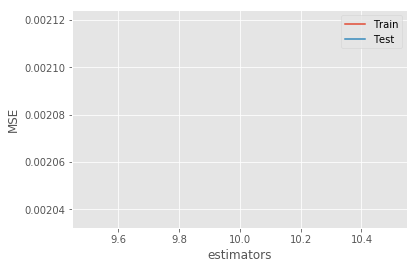

In [61]:
#estimators_range = [(i+1)*3 for i in range(20)]
estimators_range=[10]#,20,30,50
train_errors = []
test_errors = []
roc_auc = []
depth_range=[50]
estimators = 0
for estimators in estimators_range:
    for depth in depth_range:
        #model_forest = RandomForestRegressor(n_estimators = estimators,  min_samples_leaf=5)
        #model= RandomForestRegressor(n_estimators = estimators)
        #model = xgboost.XGBRegressor(n_estimators = estimators,nthread= 24,max_depth = 5)
        ##model = LogisticRegression(solver = 'lbfgs',n_jobs = -1)
        model = Ridge()
        model.fit(train_features, train_labels)
        train_predicted_labels = model.predict(train_features)

        test_predicted_labels = model.predict(test_features)

        train_errors.append(mean_squared_error(train_labels,train_predicted_labels))
        test_errors.append(mean_squared_error(test_labels,test_predicted_labels))
        roc_auc.append(roc_auc_score(test_labels,test_predicted_labels))
        #train_errors.append(mod_error(train_labels,train_predicted_labels))
        #test_errors.append(mod_error(test_labels,test_predicted_labels))
        forest_train_errors = train_errors[-1]
        forest_test_errors = test_errors[-1]
        print(forest_train_errors,forest_test_errors,roc_auc[-1])
plt.plot(estimators_range, train_errors,label = 'Train')
plt.plot(estimators_range, test_errors,label = 'Test')
#plt.plot(depth_range, train_errors,label = 'Train')
#plt.plot(depth_range, test_errors,label = 'Test')
plt.xlabel('estimators')
plt.ylabel('MSE')
plt.legend()

```
Подготавливаем тестовую выборку для подачи обученной модели
Объединяем userFeatures и itemFeatures из матриц ALS (als.fit(dfs_train_1)) построчно, 
согласно записям в dfs_test_1
```

In [62]:
dfs_test_1.show(5)

+-------+-------+
|user_id|item_id|
+-------+-------+
|   1654|  94814|
|   1654|  93629|
|   1654|   9980|
|   1654|  95099|
|   1654|  11265|
+-------+-------+
only showing top 5 rows



In [63]:
predict_sample = dfs_test_1.join(
    dfs_users_10, on = 'user_id'
).join(
    dfs_items_10, on = 'item_id'
)

Экспорт в Pandas и подготовка, аналогично обучающей выборке

In [64]:
df_t = predict_sample.select(
    'user_id',
    'item_id',
    'users_features',
    'items_features'
).toPandas()

In [65]:
df_t['features'] = df_t.users_features + df_t.items_features

In [66]:
features_for_pred = array(list(df_t['features']))

In [67]:
# features_for_pred = array(features_for_pred) # убрать

In [68]:
features_for_pred[:1]

array([[ 0.06022239,  0.02555084,  0.06670896,  0.2060701 ,  0.        ,
         0.        ,  0.        ,  0.05177906,  0.13314976,  0.0166776 ,
         0.01203247,  0.        ,  0.45102069,  0.        ,  0.        ,
         0.07030828,  0.        ,  0.        ,  0.        ,  0.        ]])

Собственно само предсказание

In [69]:
pred_list = model.predict(features_for_pred)

In [70]:
pred_list

array([ 0.01070662,  0.00147579,  0.00246144, ..., -0.00178058,
       -0.00208625, -0.00264005])

Создаем итоговый DataFrame

In [71]:
df_t['purchase'] = pred_list

In [72]:
df_t_final = df_t[['user_id','item_id','purchase']]

In [73]:
df_t_final.sort_values(['user_id','item_id'], inplace = True) # переделать, что бы Pandas не ругался

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [74]:
# df_t_final.to_csv('lab10s.csv',header=True,index = False)

In [75]:
!head lab10s.csv

user_id,item_id,purchase
1654,336,0.013781219720840454
1654,678,0.013781219720840454
1654,691,0.013781219720840454
1654,696,0.013840049505233765
1654,763,0.01366087794303894
1654,795,0.016765624284744263
1654,861,0.017134785652160645
1654,1137,0.013896673917770386
1654,1159,0.013756901025772095
